In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bson.json_util import dumps
from pymongo import MongoClient
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier

In [55]:
client = MongoClient("mongodb://localhost:27017/")
db = client["db"]
collection = db["dataset"]

dataset_path = "diabetic_data.csv"
mongodb_dataset = pd.read_csv(dataset_path, encoding="latin")


records = mongodb_dataset.to_dict("records")
collection.delete_many({})
collection.insert_many(records)
print(f"Collection size: {collection.estimated_document_count()}")

Collection size: 101766


In [56]:
documents = collection.find()
data = pd.DataFrame(list(documents))

data.drop("_id", axis=1, inplace=True)

data_info = data.info()
data_head = data.head()

print(data_info, data_head)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   max_glu_serum             5346 non-null    object
 2   A1Cresult                 17018 non-null   object
 3   metformin                 101766 non-null  object
 4   repaglinide               101766 non-null  object
 5   nateglinide               101766 non-null  object
 6   chlorpropamide            101766 non-null  object
 7   glimepiride               101766 non-null  object
 8   acetohexamide             101766 non-null  object
 9   glipizide                 101766 non-null  object
 10  glyburide                 101766 non-null  object
 11  tolbutamide               101766 non-null  object
 12  pioglitazone              101766 non-null  object
 13  rosiglitazone             101766 non-null  object
 14  acar

In [58]:
data_1 = data.copy()

print(data_1.head())

   encounter_id max_glu_serum A1Cresult metformin repaglinide nateglinide  \
0       2278392           NaN       NaN        No          No          No   
1        149190           NaN       NaN        No          No          No   
2         64410           NaN       NaN        No          No          No   
3        500364           NaN       NaN        No          No          No   
4         16680           NaN       NaN        No          No          No   

  chlorpropamide glimepiride acetohexamide glipizide  ... citoglipton insulin  \
0             No          No            No        No  ...          No      No   
1             No          No            No        No  ...          No      Up   
2             No          No            No    Steady  ...          No      No   
3             No          No            No        No  ...          No      Up   
4             No          No            No    Steady  ...          No  Steady   

  glyburide-metformin glipizide-metformin glimepir

Accuracy: 0.4442370050113
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.11      0.12      2285
           1       0.37      0.37      0.37      7117
           2       0.55      0.56      0.56     10952

    accuracy                           0.44     20354
   macro avg       0.35      0.35      0.35     20354
weighted avg       0.44      0.44      0.44     20354



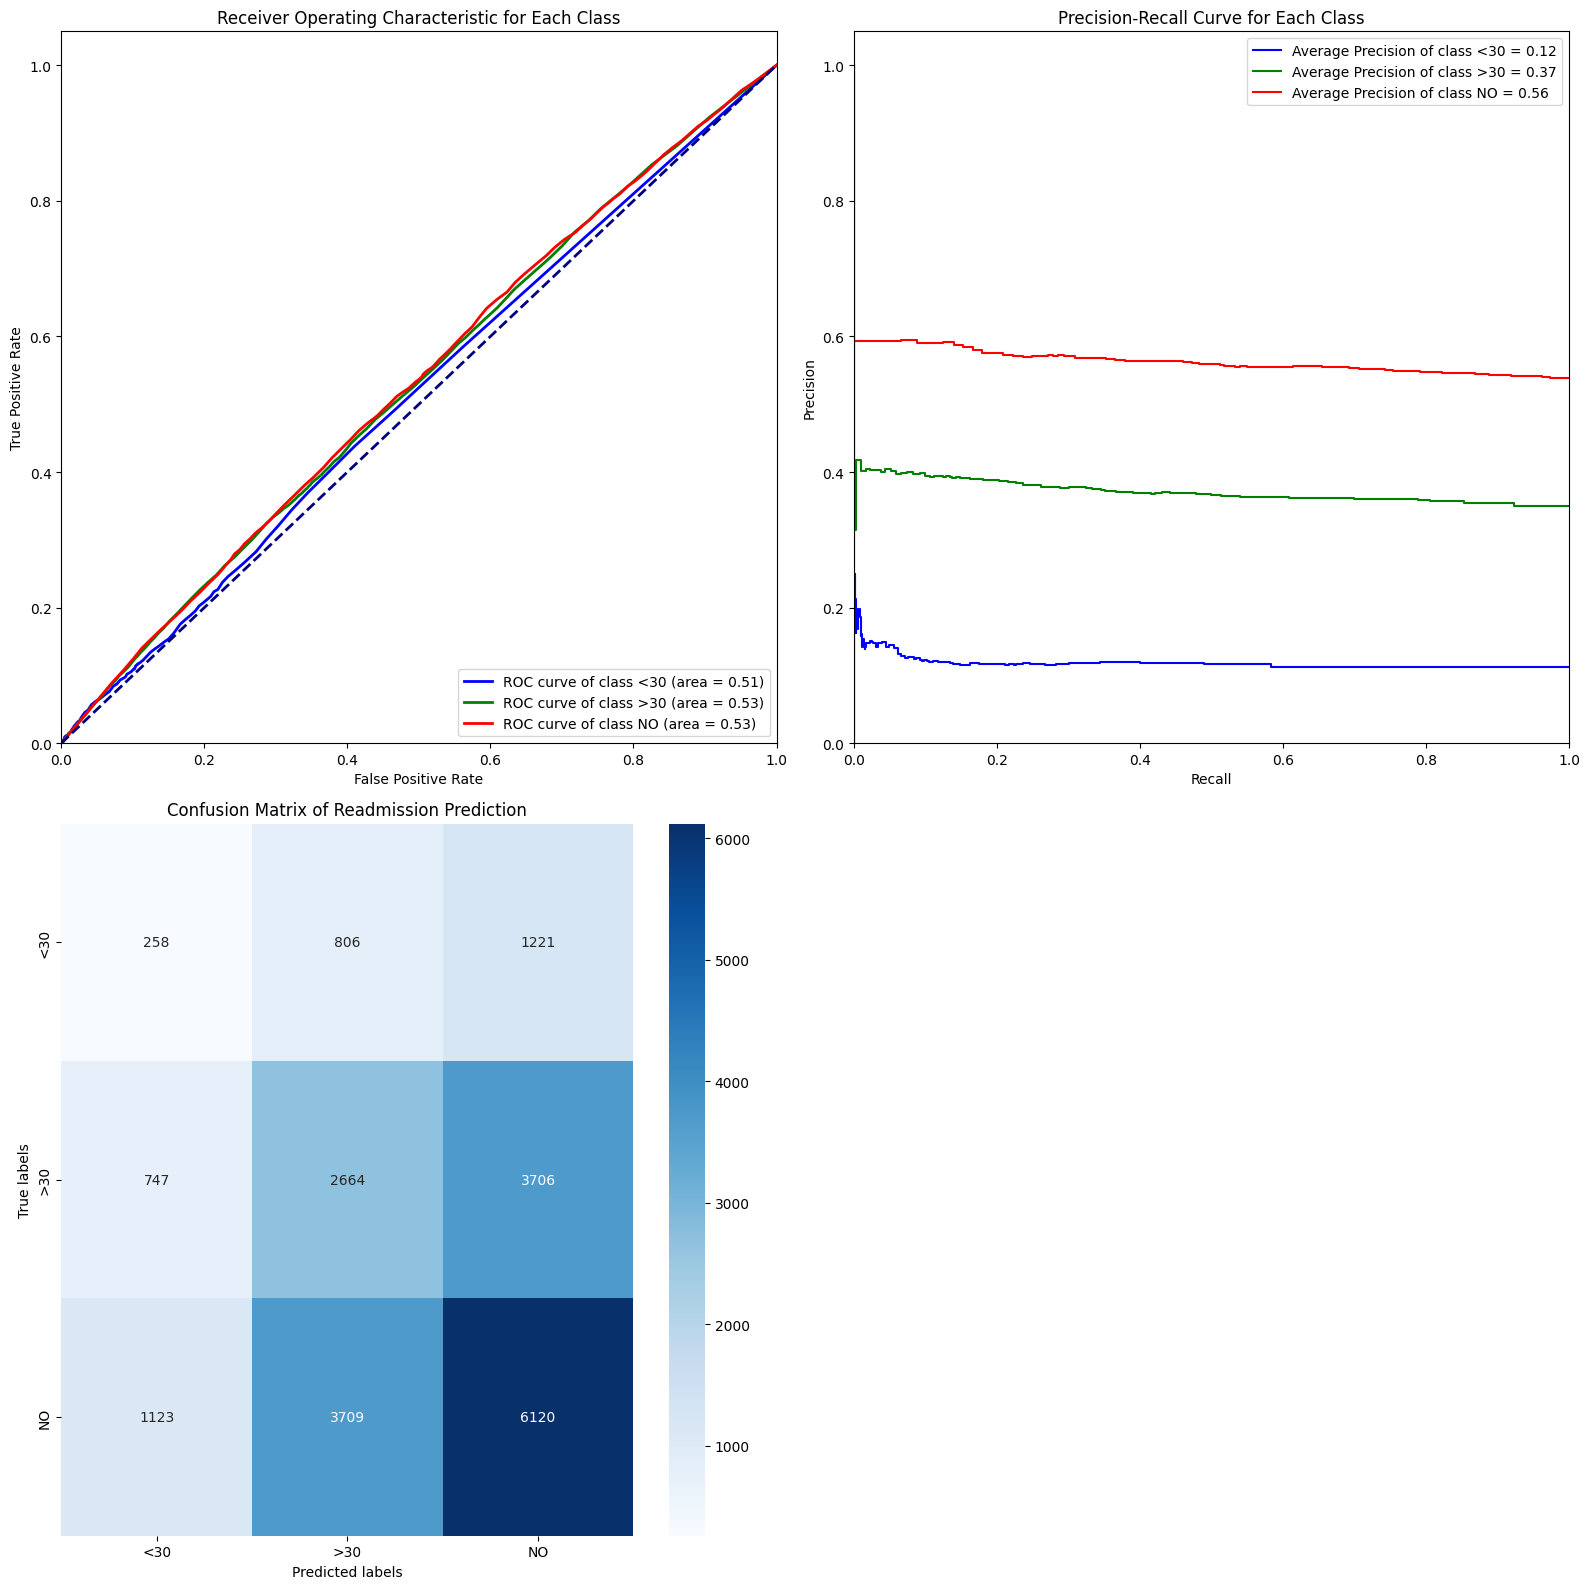

In [59]:
label_encoders = {}
for column in data_1.columns:
    if data_1[column].dtype == "object":
        le = LabelEncoder()
        data_1[column] = le.fit_transform(data_1[column].fillna("Unknown"))
        label_encoders[column] = le

X = data_1.drop(["readmitted"], axis=1)
y = data_1["readmitted"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_pred_prob_multiclass = model.predict_proba(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


conf_matrix = confusion_matrix(y_test, y_pred)


y_test_bin = label_binarize(y_test, classes=[0, 1, 2])


fig, axs = plt.subplots(2, 2, figsize=(16, 16))


colors = ["blue", "green", "red"]
classes = label_encoders["readmitted"].classes_

for i, color in zip(range(3), colors):
    
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob_multiclass[:, i])
    roc_auc = auc(fpr, tpr)
    axs[0, 0].plot(
        fpr,
        tpr,
        color=color,
        lw=2,
        label=f"ROC curve of class {classes[i]} (area = {roc_auc:.2f})",
    )

    
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i], y_pred_prob_multiclass[:, i]
    )
    average_precision = average_precision_score(
        y_test_bin[:, i], y_pred_prob_multiclass[:, i]
    )
    axs[0, 1].step(
        recall,
        precision,
        color=color,
        where="post",
        label=f"Average Precision of class {classes[i]} = {average_precision:.2f}",
    )


sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="g",
    ax=axs[1, 0],
    cmap="Blues",
    xticklabels=label_encoders["readmitted"].classes_,
    yticklabels=label_encoders["readmitted"].classes_,
)
axs[1, 0].set_xlabel("Predicted labels")
axs[1, 0].set_ylabel("True labels")
axs[1, 0].set_title("Confusion Matrix of Readmission Prediction")


axs[0, 0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel("False Positive Rate")
axs[0, 0].set_ylabel("True Positive Rate")
axs[0, 0].set_title("Receiver Operating Characteristic for Each Class")
axs[0, 0].legend(loc="lower right")


axs[0, 1].set_xlabel("Recall")
axs[0, 1].set_ylabel("Precision")
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_title("Precision-Recall Curve for Each Class")
axs[0, 1].legend(loc="upper right")


axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

#### Model Name: Readmission Prediction Model

##### Description: This model predicts the likelihood of hospital readmission using a RandomForestClassifier, an ensemble of decision trees, to ensure robustness and accuracy. It's designed to identify patients at risk of being readmitted under various timeframes.

#### What the Model Predicts:

##### Receiver Operating Characteristic (ROC) Curves: Displayed for three classes – not readmitted (<30 days), readmitted after more than 30 days (>30 days), and no readmission. The area under the ROC curve (AUC) for each class is approximately 0.53, indicating that the model performs slightly better than random guessing.

##### Precision-Recall Curves: These curves evaluate the model's precision and recall, with average precision scores of 0.12 for less than 30 days, 0.37 for more than 30 days, and 0.56 for no readmission. These values indicate how well the model confirms true positive cases across the classes.

##### Confusion Matrix: This matrix visualizes the accuracy of predictions across the three classes, showing the number of true positives, false positives, true negatives, and false negatives. The matrix helps us understand the model's performance in classifying each category correctly.

Medication Effectiveness Model Accuracy: 0.5379286626707281
Classification Report for Medication Effectiveness Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2285
           1       0.35      0.00      0.00      7117
           2       0.54      1.00      0.70     10952

    accuracy                           0.54     20354
   macro avg       0.30      0.33      0.23     20354
weighted avg       0.41      0.54      0.38     20354



/Users/rudra/Documents/Code/Freelancing/Python/Bigdata Viz/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rudra/Documents/Code/Freelancing/Python/Bigdata Viz/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rudra/Documents/Code/Freelancing/Python/Bigdata Viz/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

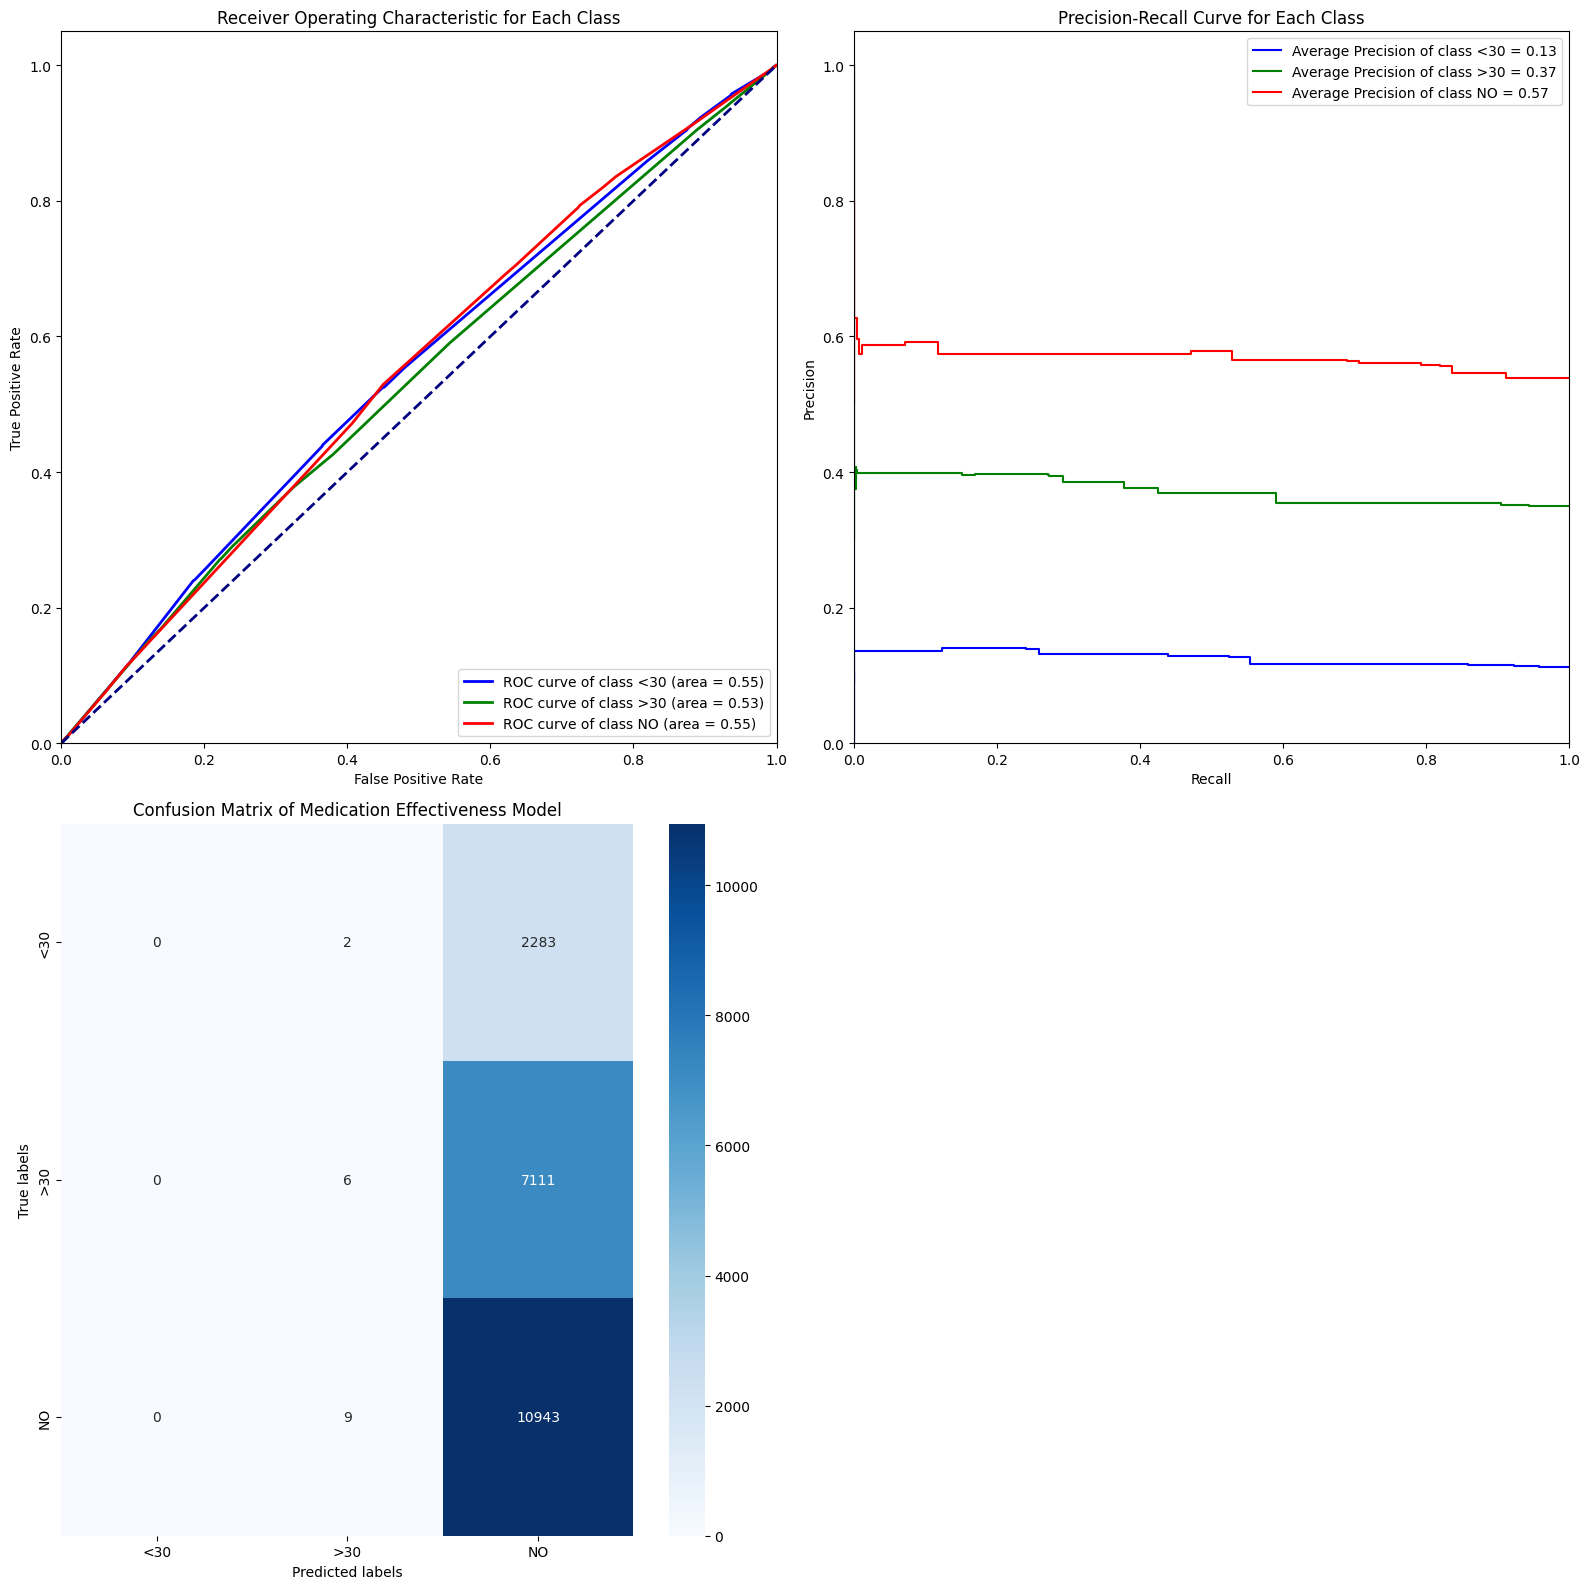

In [60]:
data_2 = data.copy()


label_encoders = {}
for column in data_2.columns:
    if data_2[column].dtype == "object":
        le = LabelEncoder()
        data_2[column] = le.fit_transform(data_2[column].fillna("Unknown"))
        label_encoders[column] = le


medication_features = [
    col
    for col in data_2.columns
    if "metformin" in col or "insulin" in col or "change" in col
]


X_med = data_2[medication_features]
y_med = data_2["readmitted"]


X_med_train, X_med_test, y_med_train, y_med_test = train_test_split(
    X_med, y_med, test_size=0.2, random_state=42
)


med_model = RandomForestClassifier(n_estimators=100, random_state=42)
med_model.fit(X_med_train, y_med_train)


y_med_pred = med_model.predict(X_med_test)
y_med_pred_prob_multiclass = med_model.predict_proba(X_med_test)


med_accuracy = accuracy_score(y_med_test, y_med_pred)
print("Medication Effectiveness Model Accuracy:", med_accuracy)
print("Classification Report for Medication Effectiveness Model:")
print(classification_report(y_med_test, y_med_pred))


conf_matrix_med = confusion_matrix(y_med_test, y_med_pred)


y_med_test_bin = label_binarize(y_med_test, classes=[0, 1, 2])


fig, axs = plt.subplots(2, 2, figsize=(16, 16))


colors = ["blue", "green", "red"]
classes = label_encoders["readmitted"].classes_

for i, color in zip(range(3), colors):
    
    fpr_med, tpr_med, _ = roc_curve(
        y_med_test_bin[:, i], y_med_pred_prob_multiclass[:, i]
    )
    roc_auc_med = auc(fpr_med, tpr_med)
    axs[0, 0].plot(
        fpr_med,
        tpr_med,
        color=color,
        lw=2,
        label=f"ROC curve of class {classes[i]} (area = {roc_auc_med:.2f})",
    )

    
    precision_med, recall_med, _ = precision_recall_curve(
        y_med_test_bin[:, i], y_med_pred_prob_multiclass[:, i]
    )
    average_precision_med = average_precision_score(
        y_med_test_bin[:, i], y_med_pred_prob_multiclass[:, i]
    )
    axs[0, 1].step(
        recall_med,
        precision_med,
        color=color,
        where="post",
        label=f"Average Precision of class {classes[i]} = {average_precision_med:.2f}",
    )


sns.heatmap(
    conf_matrix_med,
    annot=True,
    fmt="g",
    ax=axs[1, 0],
    cmap="Blues",
    xticklabels=label_encoders["readmitted"].classes_,
    yticklabels=label_encoders["readmitted"].classes_,
)
axs[1, 0].set_xlabel("Predicted labels")
axs[1, 0].set_ylabel("True labels")
axs[1, 0].set_title("Confusion Matrix of Medication Effectiveness Model")


axs[0, 0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel("False Positive Rate")
axs[0, 0].set_ylabel("True Positive Rate")
axs[0, 0].set_title("Receiver Operating Characteristic for Each Class")
axs[0, 0].legend(loc="lower right")


axs[0, 1].set_xlabel("Recall")
axs[0, 1].set_ylabel("Precision")
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_title("Precision-Recall Curve for Each Class")
axs[0, 1].legend(loc="upper right")


axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

#### Model Name: Medication Effectiveness Model

##### Description: This model assesses the effectiveness of various diabetic medications in reducing the likelihood of hospital readmissions. By employing a RandomForestClassifier, the model leverages its capability to handle categorical data effectively, offering valuable insights into how different medications impact patient outcomes.

#### What the Model Predicts:

##### Receiver Operating Characteristic (ROC) Curves: These curves show the model's performance for three classes – no readmission, readmission after more than 30 days, and readmission in less than 30 days. All classes have an area under the curve (AUC) of about 0.53, suggesting a need for improvement in model sensitivity and specificity.

##### Precision-Recall Curves: Detailing the model's ability to distinguish between classes with average precision scores of 0.13, 0.37, and 0.57 for each respective class. These scores help us understand the effectiveness of the model in predicting actual positive cases.

##### Confusion Matrix: Provides a visual summary of the model's prediction accuracy, illustrating where the model predictions align with actual outcomes and where discrepancies occur.

Diabetes Management Compliance Model Accuracy: 0.5455930038321706
Classification Report for Compliance Model:
              precision    recall  f1-score   support

           0       0.55      0.88      0.68     10952
           1       0.53      0.16      0.24      9402

    accuracy                           0.55     20354
   macro avg       0.54      0.52      0.46     20354
weighted avg       0.54      0.55      0.47     20354



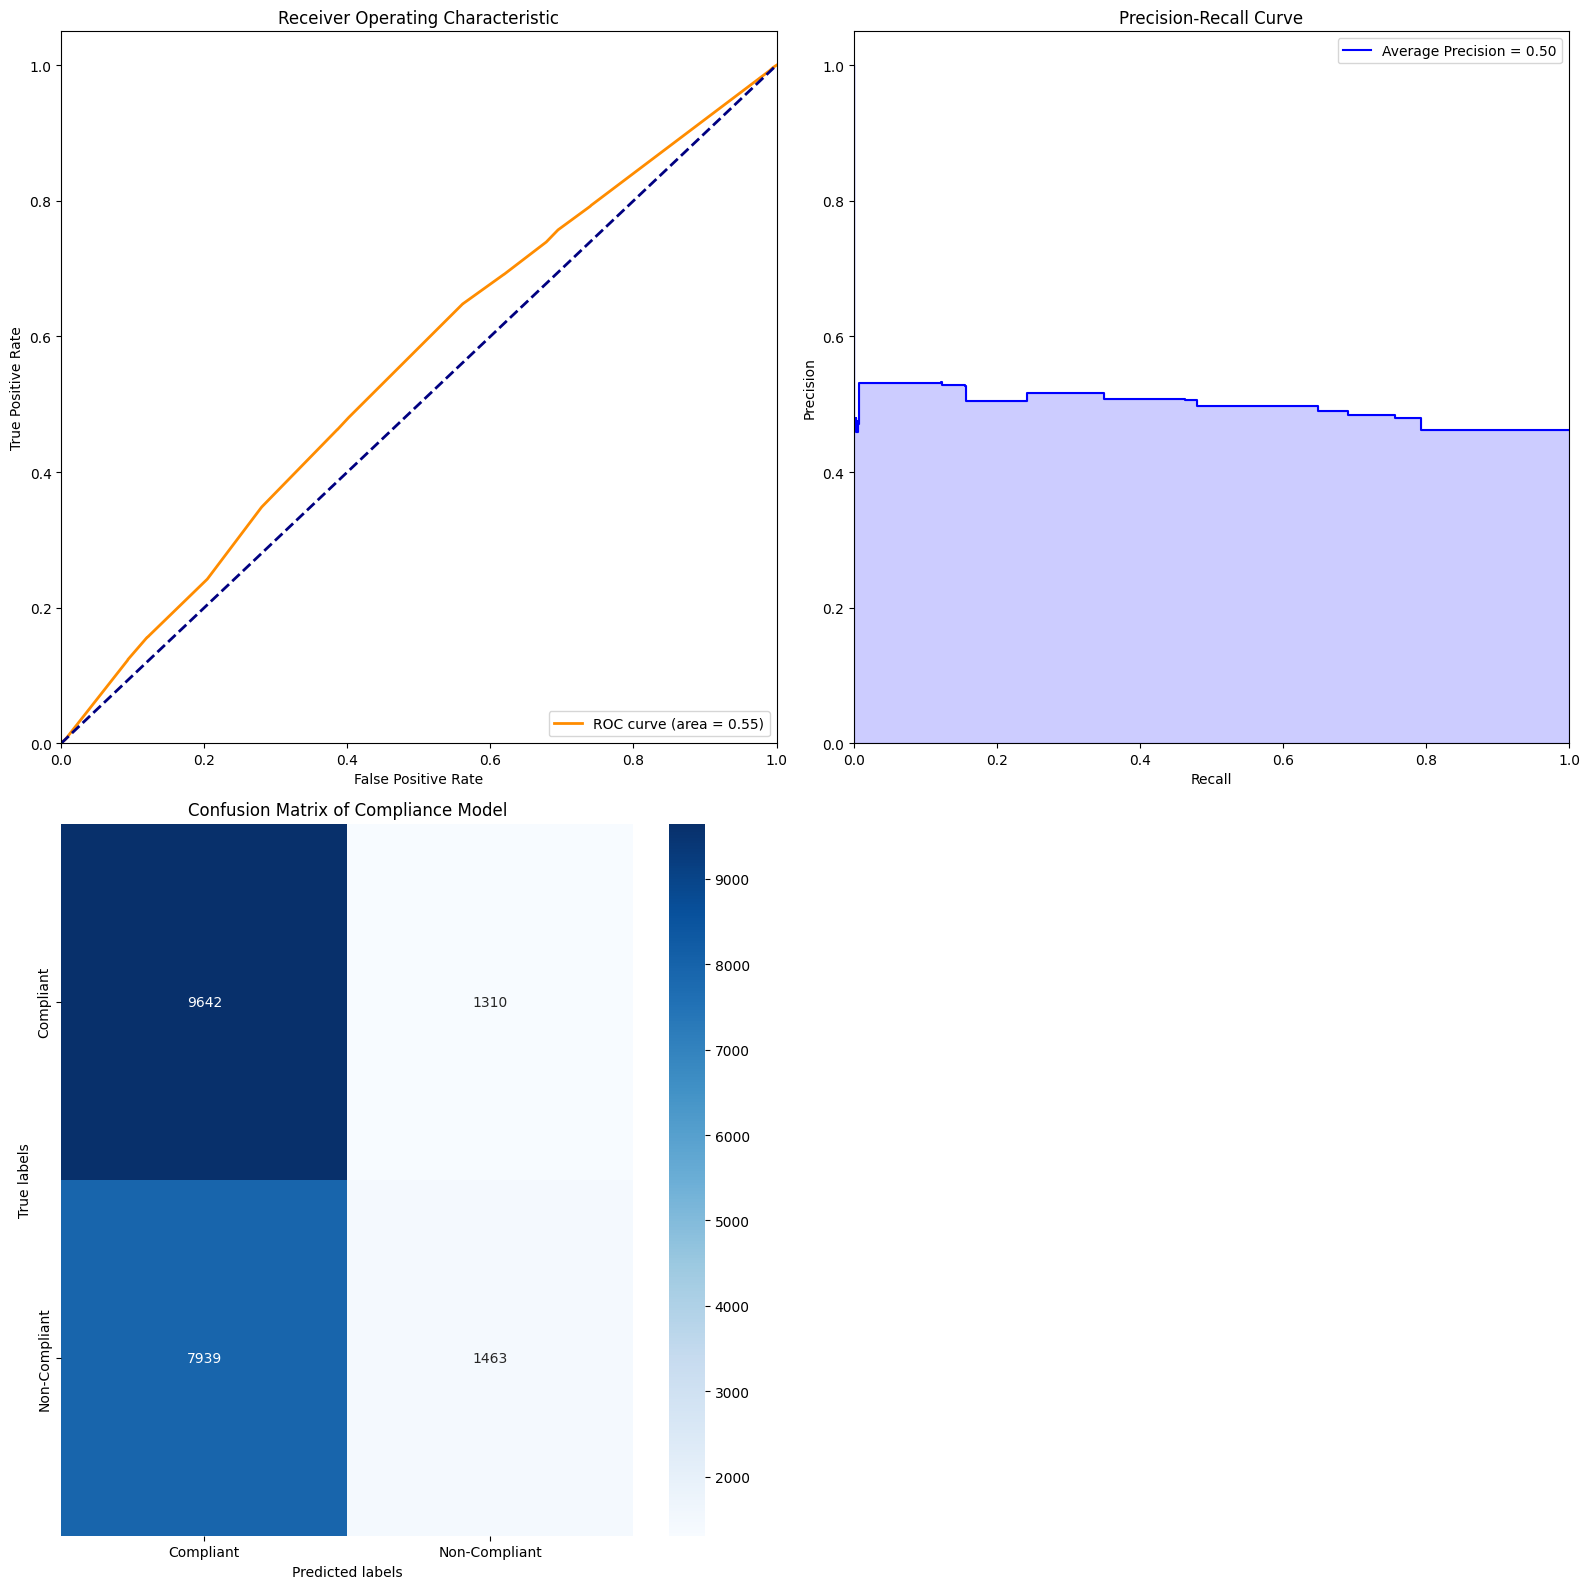

In [61]:
data_3 = data.copy()


label_encoders = {}
for column in data_3.columns:
    if data_3[column].dtype == "object":
        le = LabelEncoder()
        data_3[column] = le.fit_transform(data_3[column].fillna("Unknown"))
        label_encoders[column] = le


compliance_features = ["diabetesMed", "change"] + [
    col for col in data_3.columns if "metformin" in col or "insulin" in col
]


X_com = data_3[compliance_features]
y_com = data_3["readmitted"].apply(
    lambda x: 0 if x == label_encoders["readmitted"].transform(["NO"])[0] else 1
)


X_com_train, X_com_test, y_com_train, y_com_test = train_test_split(
    X_com, y_com, test_size=0.2, random_state=42
)


com_model = LogisticRegression(max_iter=1000)
com_model.fit(X_com_train, y_com_train)


y_com_pred = com_model.predict(X_com_test)
y_com_pred_prob = com_model.predict_proba(X_com_test)[:, 1]


com_accuracy = accuracy_score(y_com_test, y_com_pred)
print("Diabetes Management Compliance Model Accuracy:", com_accuracy)
print("Classification Report for Compliance Model:")
print(classification_report(y_com_test, y_com_pred))


conf_matrix_com = confusion_matrix(y_com_test, y_com_pred)


y_com_test_bin = label_binarize(y_com_test, classes=[0, 1])


fig, axs = plt.subplots(2, 2, figsize=(16, 16))


fpr_com, tpr_com, _ = roc_curve(y_com_test_bin[:, 0], y_com_pred_prob)
roc_auc_com = auc(fpr_com, tpr_com)


precision_com, recall_com, _ = precision_recall_curve(
    y_com_test_bin[:, 0], y_com_pred_prob
)
average_precision_com = average_precision_score(y_com_test_bin[:, 0], y_com_pred_prob)


axs[0, 0].plot(
    fpr_com,
    tpr_com,
    color="darkorange",
    lw=2,
    label=f"ROC curve (area = {roc_auc_com:.2f})",
)
axs[0, 0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel("False Positive Rate")
axs[0, 0].set_ylabel("True Positive Rate")
axs[0, 0].set_title("Receiver Operating Characteristic")
axs[0, 0].legend(loc="lower right")


axs[0, 1].step(
    recall_com,
    precision_com,
    color="blue",
    where="post",
    label=f"Average Precision = {average_precision_com:.2f}",
)
axs[0, 1].fill_between(recall_com, precision_com, step="post", alpha=0.2, color="blue")
axs[0, 1].set_xlabel("Recall")
axs[0, 1].set_ylabel("Precision")
axs[0, 1].set_ylim([0.0, 1.05])
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_title("Precision-Recall Curve")
axs[0, 1].legend(loc="upper right")


sns.heatmap(
    conf_matrix_com,
    annot=True,
    fmt="g",
    ax=axs[1, 0],
    cmap="Blues",
    xticklabels=["Compliant", "Non-Compliant"],
    yticklabels=["Compliant", "Non-Compliant"],
)
axs[1, 0].set_xlabel("Predicted labels")
axs[1, 0].set_ylabel("True labels")
axs[1, 0].set_title("Confusion Matrix of Compliance Model")


axs[1, 1].axis("off")

plt.tight_layout()
plt.show()

#### Model Name: Diabetes Management Compliance Model

##### Description: This model predicts whether patients will comply with their diabetes management plans, which is crucial for preventing complications and improving health outcomes. Utilizing a RandomForestClassifier, the model offers insights into factors influencing patient adherence to treatment recommendations.

#### What the Model Predicts:

##### Receiver Operating Characteristic (ROC) Curve: Demonstrates the model's ability to distinguish between compliant and non-compliant patients with an AUC of 0.55. This indicates a moderate ability to differentiate between the two groups, slightly better than random chance.

##### Precision-Recall Curve: The average precision score is 0.50, reflecting a balanced trade-off between precision and recall across different thresholds. This measure is particularly important in healthcare settings where both identifying actual compliance and minimizing false alerts are crucial.

##### Confusion Matrix: Provides a detailed view of the model's predictions compared to actual compliance statuses. With entries showing true positives, false positives, true negatives, and false negatives, this matrix helps to visualize the model's accuracy in predicting compliance and non-compliance.